# Visualization for images during transform augmentation

This tutorial shows how to visualize image with `matplotlib` based on MONAI `matshow3d` API, with `TensorBoard` based on MONAI `plot_2d_or_3d_image` API, with `ITKWidgets`. Also shows how to blend 2 images with the same shape.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/transform_visualization.ipynb)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from monai.utils import first, set_determinism
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    SqueezeDimd,
    EnsureTyped,
)
from monai.data import DataLoader, Dataset
from monai.config import print_config
from monai.apps import download_and_extract
from monai.visualize import matshow3d
import numpy as np
import tempfile
import shutil
import os
import glob

In [ ]:
print_config()

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


## Download dataset

Downloads and extracts the dataset.  
Here we use the `images` and `labels` of spleen 3D segmentation task, comes from http://medicaldecathlon.com/.

In [3]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [4]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

## Set deterministic training for reproducibility

In [5]:
set_determinism(seed=0)

## Setup MONAI transforms

In [6]:
transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    EnsureTyped(keys=["image", "label"]),
])

## Get the transform results in DataLoader

In [7]:
check_ds = Dataset(data=data_dicts, transform=transform)
check_loader = DataLoader(check_ds, batch_size=1)
data = first(check_loader)
print(f"image shape: {data['image'].shape}, label shape: {data['label'].shape}")

image shape: torch.Size([1, 1, 329, 282, 136]), label shape: torch.Size([1, 1, 329, 282, 136])


## Visualize the image with MONAI `matshow3d` API

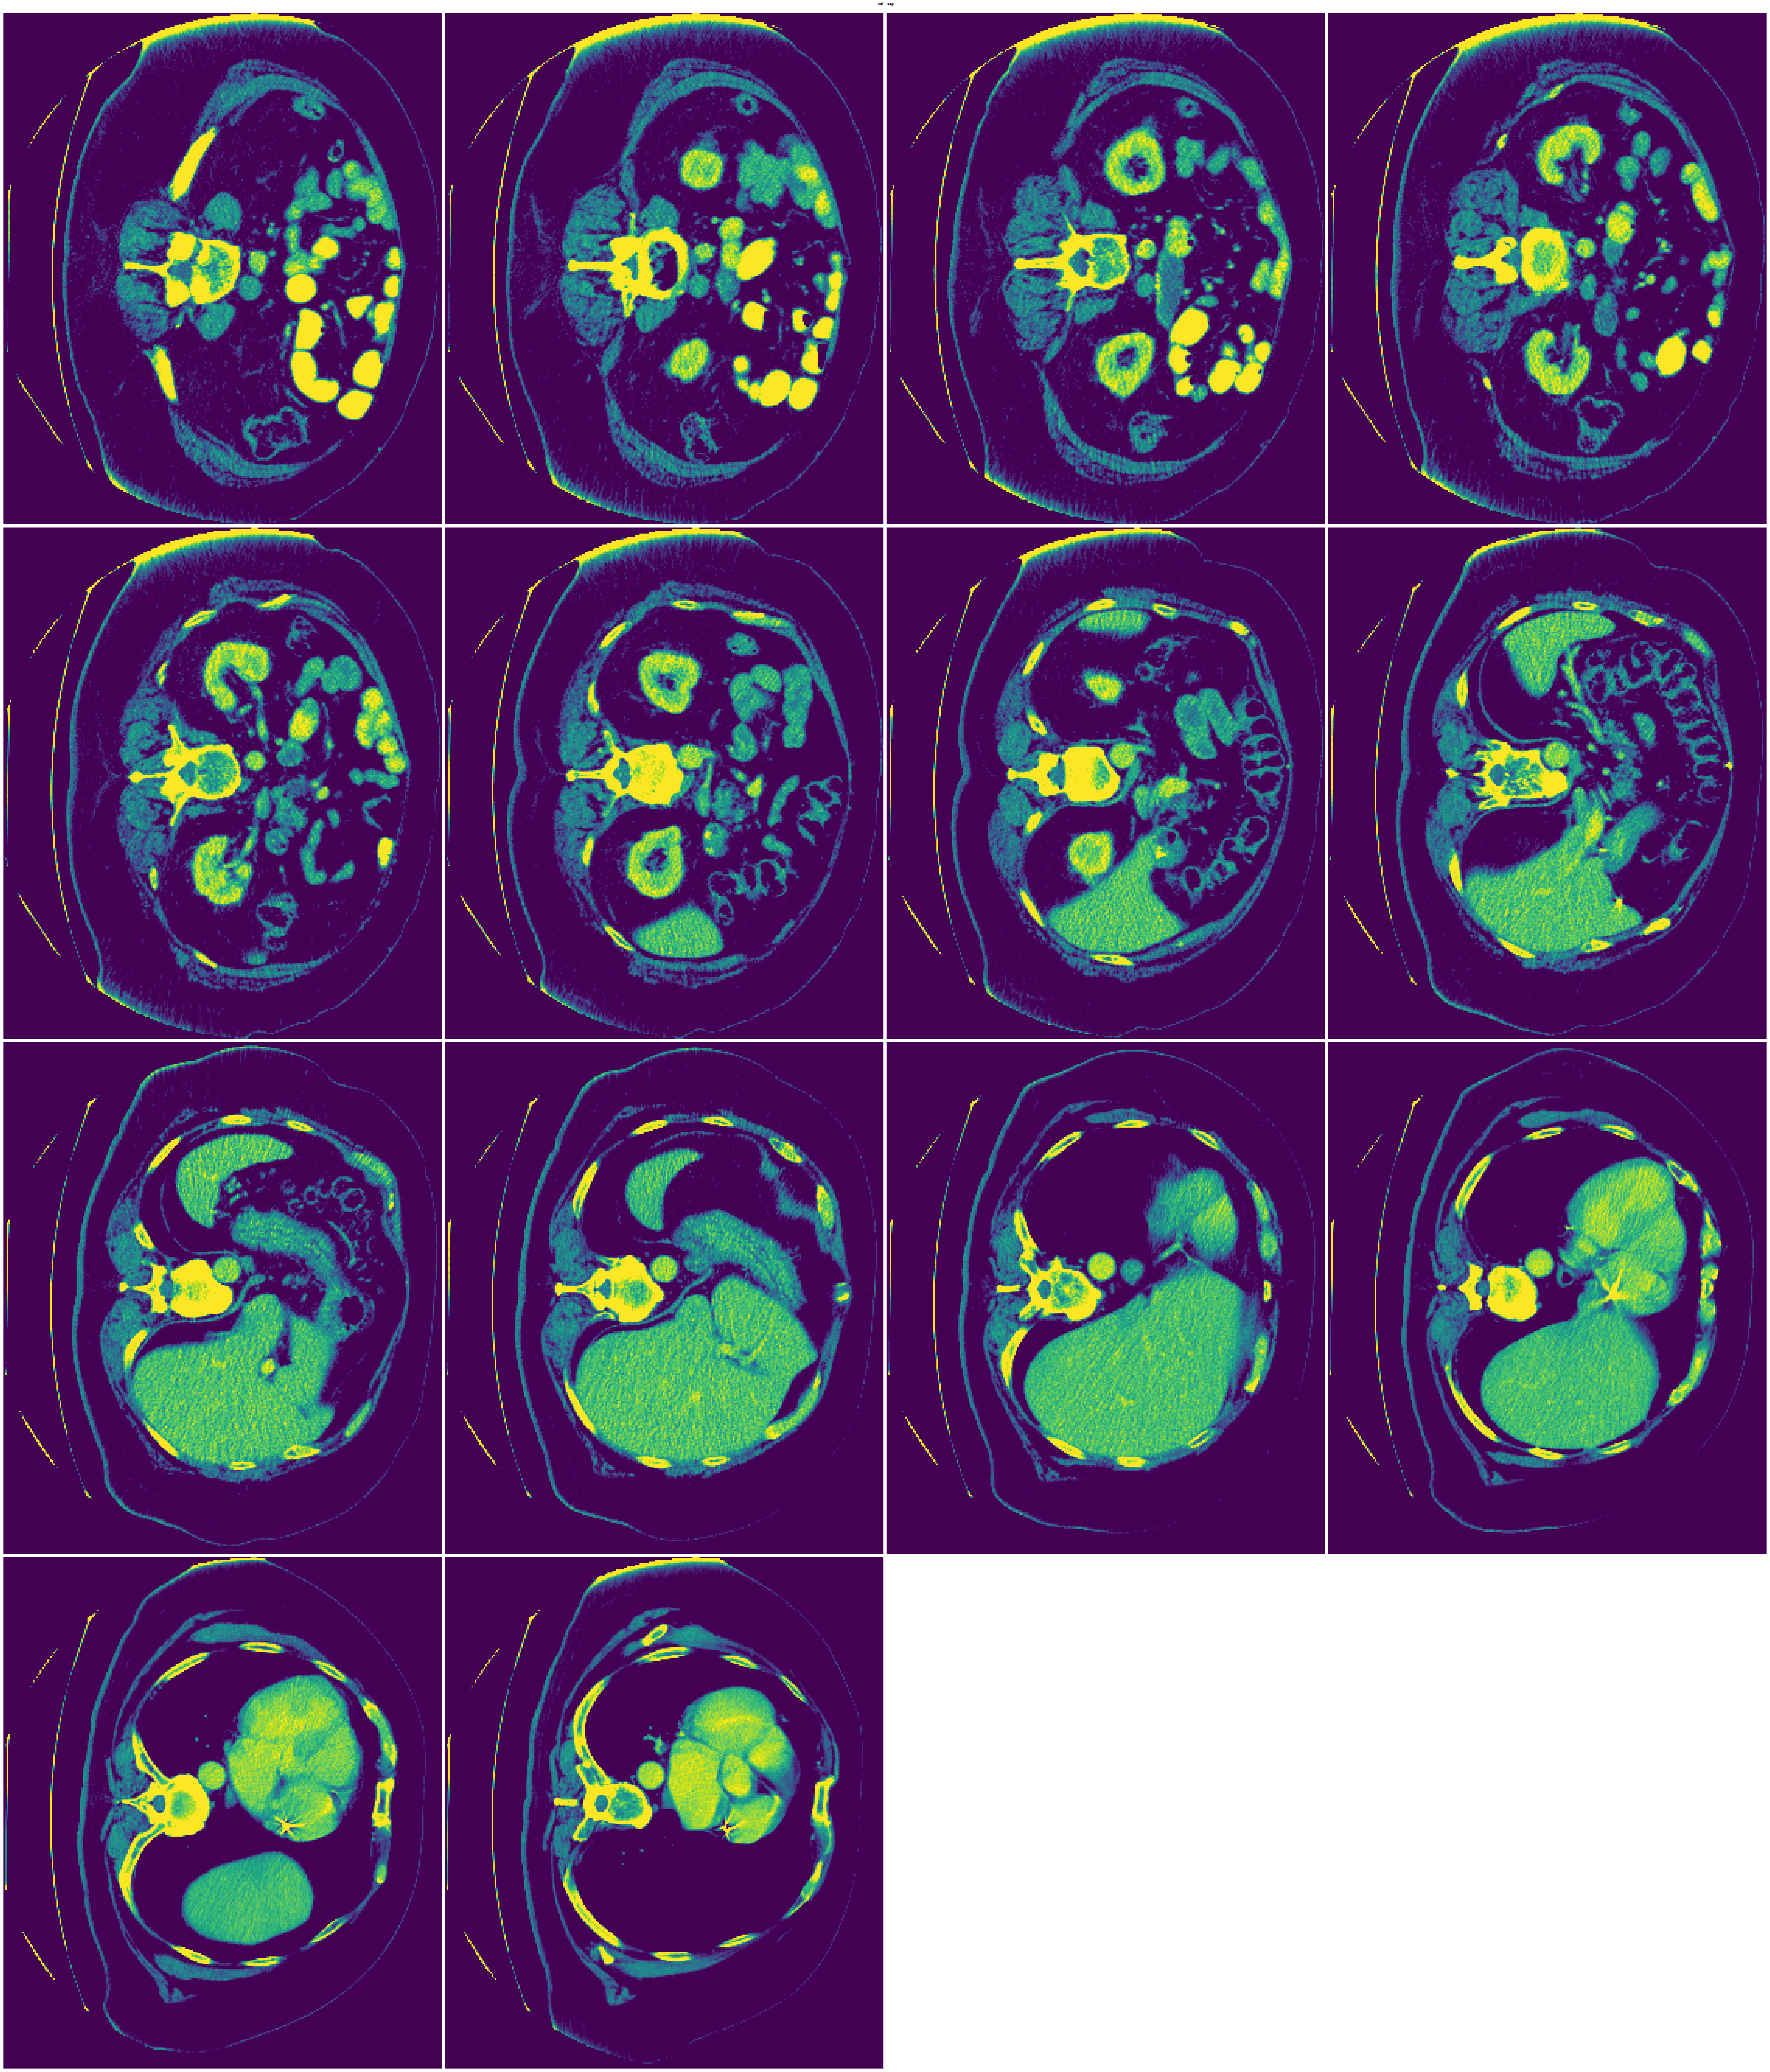

(<Figure size 7200x7200 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

In [8]:
matshow3d(volume=data['image'], fig=None, title="input image", figsize=(100, 100), every_n=10, frame_dim=-1, show=True)

## Visualize the 3D image and label in TensorBoard as GIF images

## Visualize the image and label with `ITKWidgets`

## Blend the image and label to check the segmentation region

## Cleanup data directory

Remove directory if a temporary was used.

In [14]:
if directory is None:
    shutil.rmtree(root_dir)